#Download and install packages | Data

In [0]:
%%capture
!pip install kaggle
!pip install fastai==0.7.0
!pip install torchtext==0.2.3
!pip install ggplot
!pip install pdpbox

In [0]:
!rm data/*
!rm *
!kaggle competitions download -p data -c pubg-finish-placement-prediction

rm: cannot remove 'data': Is a directory
rm: cannot remove 'sample_data': Is a directory
100% 16.9M/16.9M [00:00<00:00, 174MB/s]

 90% 88.0M/98.3M [00:00<00:00, 161MB/s]
100% 98.3M/98.3M [00:00<00:00, 228MB/s]
100% 238M/239M [00:01<00:00, 183MB/s]
100% 239M/239M [00:01<00:00, 178MB/s]


In [0]:
!ls -l sample_data

total 55504
-r-xr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Nov 29 18:21 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Nov 29 18:21 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Nov 29 18:21 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Nov 29 18:21 mnist_train_small.csv
-r-xr-xr-x 1 root root      903 Jan  1  2000 README.md


In [0]:
!unzip "data/*.zip" -d data
!ls -l data

Archive:  data/test_V2.csv.zip
  inflating: data/test_V2.csv        

Archive:  data/train_V2.csv.zip
  inflating: data/train_V2.csv       

Archive:  data/sample_submission_V2.csv.zip
  inflating: data/sample_submission_V2.csv  

3 archives were successfully processed.
total 1305716
---------- 1 root root  32880974 Oct 18 23:51 sample_submission_V2.csv
-rw-r--r-- 1 root root  17688220 Nov 29 15:25 sample_submission_V2.csv.zip
---------- 1 root root 273239581 Oct 18 23:51 test_V2.csv
-rw-r--r-- 1 root root 103060373 Nov 29 15:25 test_V2.csv.zip
---------- 1 root root 659540495 Oct 18 23:51 train_V2.csv
-rw-r--r-- 1 root root 250618121 Nov 29 15:25 train_V2.csv.zip


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.structured import *
import pandas as pd

from sklearn.ensemble import *
from sklearn.model_selection import *
from IPython.display import display

from ggplot import *
from sklearn.metrics import *
from scipy.cluster import hierarchy as hc
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Download all the training data into csv files

In [0]:
%%time
train = pd.read_csv(f'data/train_V2.csv')
test = pd.read_csv(f'data/test_V2.csv')
samp_sub = pd.read_csv(f'data/sample_submission_V2.csv')

CPU times: user 40.1 s, sys: 4.24 s, total: 44.4 s
Wall time: 44.4 s


In [0]:
%%time
valid = pd.merge(test, samp_sub, how = 'inner', left_on = "Id", right_on ="Id")

CPU times: user 4.76 s, sys: 38.8 ms, total: 4.8 s
Wall time: 4.78 s


In [0]:
train.shape

(4446966, 29)

In [0]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

#Build initial Random Forest

In [0]:
#Take a smaller% sample of the data for training
perc = 0.01
train_small=train.sample(n = round(train.shape[0]*perc), random_state = 42)
valid_small = valid.sample(n = round(valid.shape[0]*perc), random_state = 42)

In [0]:
valid_small.shape

(19342, 29)

In [0]:
train_cats(train_small)

In [0]:
#Show that the categories have been successfully assigned
train_small.matchType.cat.categories

Index(['crashfpp', 'crashtpp', 'duo', 'duo-fpp', 'flarefpp', 'flaretpp',
       'normal-duo-fpp', 'normal-solo', 'normal-solo-fpp', 'normal-squad',
       'normal-squad-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp'],
      dtype='object')

In [0]:
df, y, nas = proc_df(train_small, 'winPlacePerc', max_n_cat=7)

In [0]:
#Create random training and testing samples
#Use only reduced columns of model to predict random forest 
X_train, X_test, y_train, y_test = train_test_split(
    df, y, 
    test_size=0.5, random_state=42)
print("X Train Shape: " + str(X_train.shape))
print("y Train Shape: " + str(y_train.shape))
print("X Test Shape: " + str(X_test.shape))
print("y Test Shape: " + str(y_test.shape))

X Train Shape: (22235, 28)
y Train Shape: (22235,)
X Test Shape: (22235, 28)
y Test Shape: (22235,)


In [0]:
def print_score(m, X_train, y_train, X_test, y_test, verbose = True):
  if verbose:
    print("R**2 Score of model: " + str(m.score(X_train, y_train)))
    print("Mean Abs Error: " + str(mean_absolute_error(y_test, m.predict(X_test))))
    print("OOB Score: " + str(m.oob_score_))
  else:
    return m.score(X_train, y_train), mean_absolute_error(y_test, m.predict(X_test)), m.oob_score_;

In [0]:
#Sample run to test that random forrest is working and function above is working correctly
%%time 
set_rf_samples(10000)
m = RandomForestRegressor(n_estimators = 10, 
                          random_state = 42,
                          criterion = 'mae', n_jobs = 2, 
                          min_samples_leaf=100, 
                          max_features = 'sqrt',
                          oob_score = True
                          )
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


R**2 Score of model: 0.8338987677773342
Mean Abs Error: 0.09018178727231842
OOB Score: 0.8226661825936752
CPU times: user 16.9 s, sys: 14.5 ms, total: 16.9 s
Wall time: 8.89 s


#Feature Engineering
###Analyze features in dataset and select/engineer important features

In [0]:
#Check out variable importance of columns of training data
pd.DataFrame(m.feature_importances_, index = df.columns, columns=['importance']).sort_values(by = 'importance', ascending = False)

,importance
walkDistance,0.389821
boosts,0.184126
killPlace,0.160285
weaponsAcquired,0.069802
heals,0.054631
damageDealt,0.032307
longestKill,0.030936
kills,0.024728
assists,0.010798
revives,0.007712


In [0]:
fi = rf_feat_importance(m, df); fi[:10] #Print out top ten important features

,cols,imp
25,walkDistance,0.389821
4,boosts,0.184126
9,killPlace,0.160285
26,weaponsAcquired,0.069802
8,heals,0.054631
5,damageDealt,0.032307
13,longestKill,0.030936
11,kills,0.024728
3,assists,0.010798
19,revives,0.007712


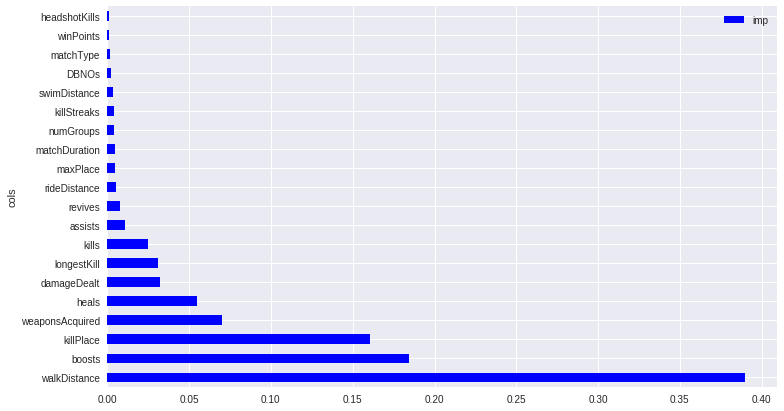

In [0]:
fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), color='blue')

In [0]:
to_keep = fi[fi.imp>0.001].cols;
print(to_keep)
print(len(to_keep))
#This gives the top 19 features

25       walkDistance
4              boosts
9           killPlace
26    weaponsAcquired
8               heals
5         damageDealt
13        longestKill
11              kills
3             assists
19            revives
20       rideDistance
16           maxPlace
14      matchDuration
17          numGroups
12        killStreaks
22       swimDistance
6               DBNOs
15          matchType
Name: cols, dtype: object
18


In [0]:
#Use only reduced columns of model to predict random forest 
df_keep = train_small[to_keep].copy()
train_cats(df_keep)
df_keep, _, nas = proc_df(df_keep, max_n_cat=7)
print(df_keep.head())
X_train, X_test, y_train, y_test = train_test_split(
    df_keep, train_small.winPlacePerc, 
    test_size=0.5, random_state=42)
print("X Train Shape: " + str(X_train.shape))
print("y Train Shape: " + str(y_train.shape))
print("X Test Shape: " + str(X_test.shape))
print("y Test Shape: " + str(y_test.shape))

         walkDistance  boosts  killPlace  weaponsAcquired  heals  damageDealt  \
4289863         565.3       0          7                2      0        161.3   
3353859         532.6       3          7                3      4        191.5   
1660760        1607.0       2         24                6      1        100.0   
2555773         134.6       0         86                1      0          0.0   
363725         2131.0       2         14                5      9        289.9   

         longestKill  kills  assists  revives  rideDistance  maxPlace  \
4289863        41.54      4        0        1           0.0        29   
3353859         4.14      3        0        0        1580.0        40   
1660760        64.25      1        0        0         450.7        97   
2555773         0.00      0        0        0           0.0        27   
363725         22.46      2        3        1        3950.0        28   

         matchDuration  numGroups  killStreaks  swimDistance  DBNOs  match

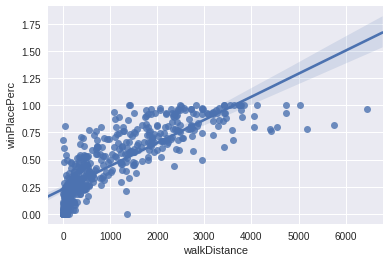

In [0]:
df_keep_all=get_sample(df_keep.join(train_small.winPlacePerc), 500)
sns.regplot(x="walkDistance", y = 'winPlacePerc', data = df_keep_all, ci = 99)

In [0]:
from pdpbox import pdp
from plotnine import *
import feather

In [0]:
def plot_pdp(feat, clusters = None, feat_name = None):
  feat_name = feat_name or feat
  p = pdp.pdp_isolate(m, x, model_features = x.columns,feature=feat)
  return pdp.pdp_plot(p, feat_name, plot_lines = True,
                     cluster = clusters is not None, n_cluster_centers = clusters)

In [0]:
%%time 
set_rf_samples(10000)
m = RandomForestRegressor(n_estimators = 10, 
                          random_state = 42,
                          criterion = 'mae', n_jobs = 2, 
                          min_samples_leaf=100, 
                          max_features = 'sqrt')
m.fit(X_train, y_train)
print(m.score(X_train,y_train))
print(mean_absolute_error(y_test, m.predict(X_test)))
#learn here that removing some of the useless columns helps with model performance

0.8526298379588423
0.08380092961547111
CPU times: user 11.9 s, sys: 7.94 ms, total: 11.9 s
Wall time: 6.24 s


(<matplotlib.figure.Figure at 0x7f40930e5e80>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f403b34fa58>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f403b39bf60>})

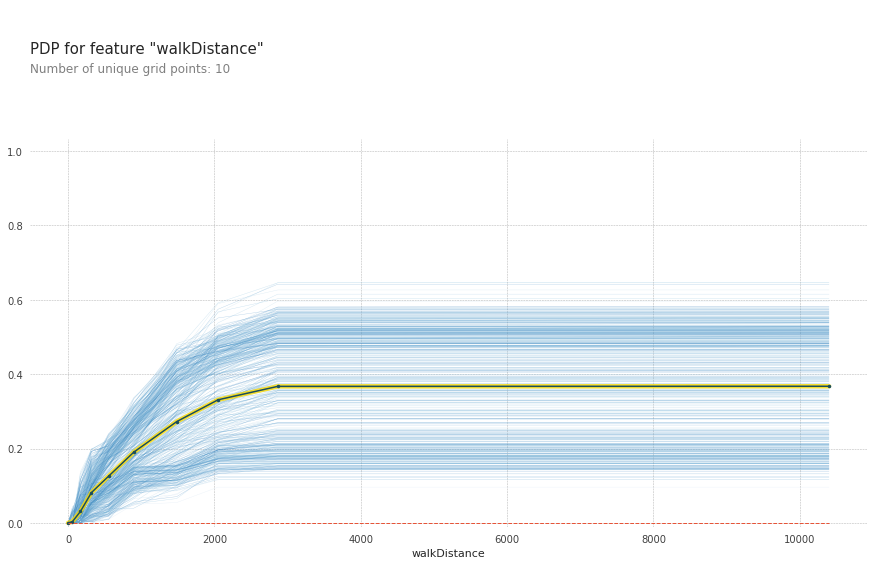

In [0]:
x=get_sample(X_train, 500)
plot_pdp(feat='walkDistance')

(<matplotlib.figure.Figure at 0x7f40450980b8>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4044256550>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4044301e48>})

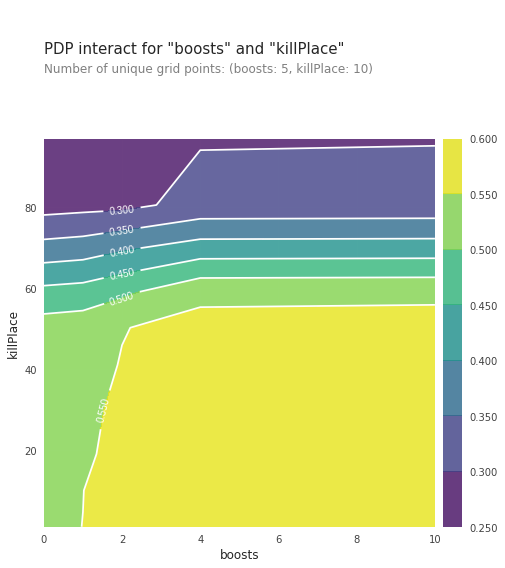

In [0]:
feats = ['boosts', 'killPlace']
p = pdp.pdp_interact(m, x, model_features = x.columns, features = feats)
pdp.pdp_interact_plot(p, feats)

In [0]:
%%time
corr = np.round(scipy.stats.spearmanr(get_sample(df_keep, 1000)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)


CPU times: user 7.91 ms, sys: 1.01 ms, total: 8.91 ms
Wall time: 9.06 ms


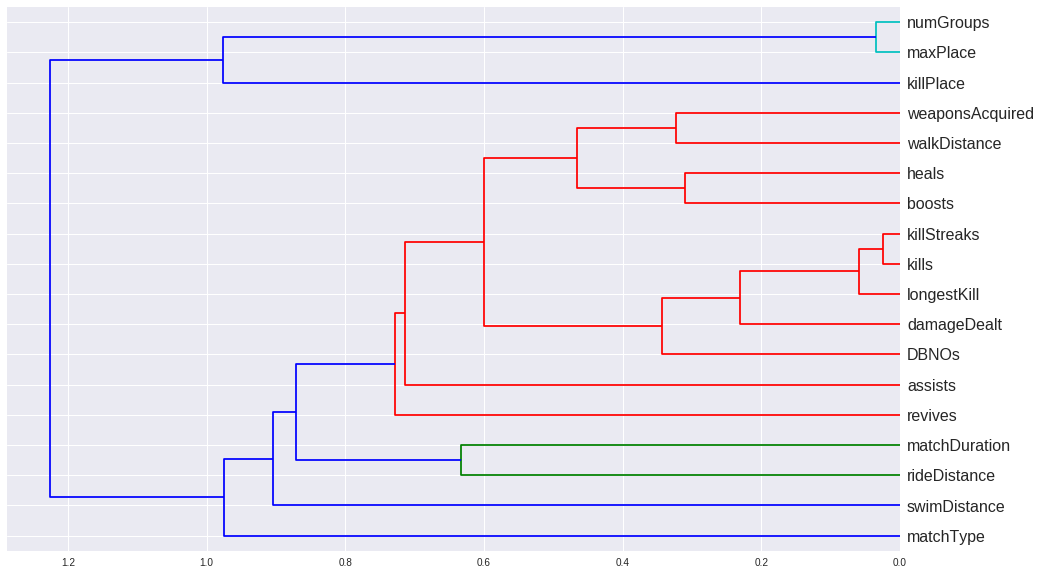

CPU times: user 387 ms, sys: 189 ms, total: 576 ms
Wall time: 335 ms


In [0]:
%%time
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize=(16,10))
dendogram = hc.dendrogram(z, labels = df_keep.columns, orientation='left', leaf_font_size = 16)
plt.show()

The dendogram plot shows that several of the variables are quite related:


*   kills - killStreaks
*   numGroups - maxPlace

Inicate we should investiate what these variables mean to see if we can eliminate any of them or consolidate them into more relevant features



In [0]:
def get_oob(X_train, y_train):
    m = RandomForestRegressor(n_estimators = 10, 
                          random_state = 42,
                          criterion = 'mae', n_jobs = 2, 
                          min_samples_leaf=100, 
                          max_features = 'sqrt',
                             oob_score = True)
    m.fit(X_train, y_train)
    return m.oob_score_

In [0]:
df_keep.columns

Index(['walkDistance', 'boosts', 'killPlace', 'weaponsAcquired', 'heals',
       'damageDealt', 'longestKill', 'kills', 'assists', 'revives',
       'rideDistance', 'maxPlace', 'matchDuration', 'numGroups', 'killStreaks',
       'swimDistance', 'DBNOs', 'matchType'],
      dtype='object')

In [0]:
#Recall that df_keep has a reduced number of columns that are relevant to selecting a winner
#Get a baseline
get_oob(X_train, y_train)

0.8441013417079838

In [0]:
for c in ('kills', 'killStreaks', 'numGroups', 'maxPlace'):
  print(c, get_oob(X_train.drop(c, axis = 1), y_train))

kills 0.8343857201768956
killStreaks 0.8285053643306607
numGroups 0.8369373244815427
maxPlace 0.8355290518884595


In [0]:
to_drop = ['kills', 'numGroups']
get_oob(X_train.drop(to_drop, axis = 1), y_train)

0.8430797075542273

In [0]:
#Use only reduced columns of model to predict random forest 
#df_keep = df_keep.drop(to_drop, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    df_keep, train_small.winPlacePerc, 
    test_size=0.5, random_state=42)
print(X_train.shape); 
print(y_train.shape);
print(X_test.shape); 
print(y_test.shape);

(22235, 18)
(22235,)
(22235, 18)
(22235,)


In [0]:
%%time
m = RandomForestRegressor(n_estimators = 10, 
                          random_state = 42,
                          criterion = 'mae', n_jobs = 2, 
                          min_samples_leaf=100, 
                          max_features = 'sqrt',
                         oob_score = True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_test, y_test)

R**2 Score of model: 0.8526298379588423
Mean Abs Error: 0.0838009296154711
OOB Score: 0.8441013417079838
CPU times: user 16.8 s, sys: 15.5 ms, total: 16.8 s
Wall time: 8.78 s


In [0]:
df_ext_trn = train_small[to_keep].copy()
df_ext_vld = valid_small[to_keep].copy()
df_ext_trn['is_valid']=0
df_ext_vld['is_valid']=1

In [0]:
to_drop = ['kills', 'numGroups']
all_data=df_ext_trn.append(df_ext_vld)
all_data = all_data.drop(to_drop, axis = 1)
train_cats(all_data)
df, y, nas = proc_df(all_data, 'is_valid', max_n_cat=3)

In [0]:
all_data.columns

Index(['walkDistance', 'boosts', 'killPlace', 'weaponsAcquired', 'heals',
       'damageDealt', 'longestKill', 'assists', 'revives', 'rideDistance',
       'maxPlace', 'matchDuration', 'killStreaks', 'swimDistance', 'DBNOs',
       'matchType', 'is_valid'],
      dtype='object')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df,y);
m.oob_score_

0.6941954491318247

This score indicates that the testing data IS randomized and not time dependent on particular variables, possibly, need to investigate feature importance

In [0]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
0,walkDistance,0.183321
11,matchDuration,0.175187
2,killPlace,0.122937
5,damageDealt,0.118449
10,maxPlace,0.084960
6,longestKill,0.067690
3,weaponsAcquired,0.056042
9,rideDistance,0.042147
15,matchType,0.032759
4,heals,0.032547


Check each of these to see how they compare between training and testing datasets

In [0]:
feats = ['walkDistance', 'matchDuration','killPlace', 'damageDealt']
train_small[feats].describe()

,walkDistance,matchDuration,killPlace,damageDealt
count,44470.000000,44470.000000,44470.000000,44470.000000
mean,1147.854288,1579.802856,47.642725,130.102363
std,1178.455193,259.680125,27.379856,170.659137
min,0.000000,352.000000,1.000000,0.000000
25%,157.800000,1367.000000,24.000000,0.000000
50%,683.650000,1439.000000,48.000000,84.000000
75%,1961.000000,1852.000000,71.000000,183.800000
max,11190.000000,2214.000000,100.000000,4014.000000


In [0]:
valid_small[feats].describe()

,walkDistance,matchDuration,killPlace,damageDealt
count,19342.000000,19342.000000,19342.000000,19342.000000
mean,1149.924302,1576.293610,47.583600,129.969836
std,1184.290106,255.944709,27.504754,168.887796
min,0.000000,598.000000,1.000000,0.000000
25%,157.900000,1366.000000,24.000000,0.000000
50%,669.350000,1436.000000,47.000000,83.850000
75%,1971.500000,1849.000000,71.000000,185.000000
max,11170.000000,2217.000000,100.000000,2212.000000


No real significant difference here between the two, importantly 'GroupID' and 'Id' do not have any time dependent nature or relevancy in differentiating between testing and validation set

Take away is keep all the above columns in to_keep 

In [0]:
train_small.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [0]:
%%time
df, y, nas = proc_df(train_small, 'winPlacePerc')
X_train, X_test, y_train, y_test = train_test_split(
   df, y, 
    test_size=0.5, random_state=42)

feats = ['Id','groupId','matchId','walkDistance', 'matchDuration','killPlace', 'damageDealt', 
         'maxPlace', 'matchDuration', 'numGroups', 'killStreaks', 'kills', 'winPoints']
res = pd.DataFrame([],columns = ['Feature', 'R**2', 'MAE','OOB'])

for f in feats:
    df_subs = X_train.drop(f, axis = 1)
    
    df_test = X_test.drop(f, axis = 1)
    m = RandomForestRegressor(n_estimators = 10, 
                          random_state = 42,
                          criterion = 'mae', n_jobs = 2, 
                          min_samples_leaf=100, 
                          max_features = 'sqrt', oob_score = True)
    m.fit(df_subs, y_train)
    r2, mae, oob = print_score(m, df_subs,y_train, df_test, y_test, verbose = False)
    res = res.append(pd.DataFrame({'Feature':[f], 'R**2':[r2], "MAE":[mae], 'OOB':oob}))

res.set_index('Feature')    
res.sort_values(by='MAE')
    
    

CPU times: user 3min 23s, sys: 108 ms, total: 3min 23s
Wall time: 1min 46s


In [0]:
res.sort_values(by='MAE')

,Feature,MAE,OOB,R**2
0,winPoints,0.087405,0.836387,0.845698
0,numGroups,0.087413,0.833555,0.844104
0,maxPlace,0.088837,0.830300,0.841144
0,matchDuration,0.088979,0.830083,0.840889
0,matchDuration,0.088979,0.830083,0.840889
0,matchId,0.089140,0.827792,0.839343
0,Id,0.089972,0.823400,0.835575
0,groupId,0.090046,0.823855,0.836111
0,damageDealt,0.090528,0.824898,0.836602
0,kills,0.090549,0.823300,0.835384


In [0]:
to_keep

25       walkDistance
4              boosts
9           killPlace
26    weaponsAcquired
8               heals
5         damageDealt
13        longestKill
11              kills
3             assists
19            revives
20       rideDistance
16           maxPlace
14      matchDuration
17          numGroups
12        killStreaks
22       swimDistance
6               DBNOs
15          matchType
Name: cols, dtype: object

In [0]:
train[to_keep]

,walkDistance,boosts,killPlace,weaponsAcquired,heals,damageDealt,longestKill,kills,assists,revives,rideDistance,maxPlace,matchDuration,numGroups,killStreaks,swimDistance,DBNOs,matchType
0,244.80,0,60,1,0,0.000,0.000,0,0,0,0.0000,28,1306,26,0,0.000,0,squad-fpp
1,1434.00,0,57,5,0,91.470,0.000,0,0,0,0.0045,26,1777,25,0,11.040,0,squad-fpp
2,161.80,0,47,2,0,68.000,0.000,0,1,0,0.0000,50,1318,47,0,0.000,0,duo
3,202.70,0,75,3,0,32.900,0.000,0,0,0,0.0000,31,1436,30,0,0.000,0,squad-fpp
4,49.75,0,45,2,0,100.000,58.530,1,0,0,0.0000,97,1424,95,1,0.000,0,solo-fpp
5,34.70,0,44,1,0,100.000,18.440,1,0,0,0.0000,28,1395,28,1,0.000,1,squad-fpp
6,13.50,0,96,1,0,0.000,0.000,0,0,0,0.0000,28,1316,28,0,0.000,0,squad-fpp
7,1089.00,0,48,6,0,8.538,0.000,0,0,0,2004.0000,96,1967,92,0,0.000,0,solo-fpp
8,799.90,0,64,4,0,51.600,0.000,0,0,0,0.0000,28,1375,27,0,0.000,0,squad
9,65.67,0,74,1,0,37.270,0.000,0,0,0,0.0000,29,1930,27,0,0.000,0,squad


In [0]:
to_keep_final=to_keep.append(pd.Series(['Id', 'winPlacePerc'])) #keep index in so that rows can be identified
final_train=train[to_keep_final]
train_cats(final_train)
df,y,nas = proc_df(final_train, 'winPlacePerc')

In [0]:
train_cols = df.columns
df.drop('Id', axis = 1).head()
y[:2]

NameError: ignored

In [0]:
%%time
reset_rf_samples()

m = RandomForestRegressor(n_estimators = 40, 
                          random_state = 42,
                          criterion = 'mae', n_jobs = 2, 
                          min_samples_leaf=10, 
                          max_features = 'sqrt', oob_score = True)
m.fit(df.drop('Id', axis = 1), y)
    

CPU times: user 15min 54s, sys: 198 ms, total: 15min 54s
Wall time: 8min 4s


In [0]:
test.shape

(1934174, 28)

In [0]:
df.shape

(44470, 28)

In [0]:
print_score(m, df.drop('Id', axis = 1), y, test.drop('Id', axis =1 ), samp_sub.drop('Id', axis =1))

R**2 Score of model: 0.9040487884508579


ValueError: ignored

##Create a final model with ALL data

In [0]:
np.random.permutation(10)[:5]

array([8, 2, 7, 6, 4])

In [0]:
train_small.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

#Grid Search for best RF Hyperparameters

In [0]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 5)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 3, 5, 10],
               'bootstrap': [True, False]}

print(random_grid)

{'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 35, 60, 85, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 5, 10], 'bootstrap': [True, False]}


In [0]:
%%time
rf=RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 2)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1550, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=110, bootstrap=False 
[CV] n_estimators=1550, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1550, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=110, bootstrap=False, total= 1.6min
[CV] n_estimators=1550, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1550, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=110, bootstrap=False, total= 1.6min
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=3, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=3, max_features=auto, max_depth=60, bootstrap=False, total=  59.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=3, max_features=auto

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 46.3min


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=10, bootstrap=True, total= 4.5min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=10, bootstrap=True, total= 4.5min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=False 


In [0]:
rf_random.best_params_

In [0]:
mean_absolute_error(y, m.predict(df))

In [0]:
?np.log1p

In [0]:
%time add_datepart(df_all, 'date')

CPU times: user 3.62 s, sys: 664 ms, total: 4.29 s
Wall time: 4.3 s


In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [0]:
df_test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,True
1,125497041,2017-08-16,1,99197,True
2,125497042,2017-08-16,1,103501,True
3,125497043,2017-08-16,1,103520,True
4,125497044,2017-08-16,1,103665,True


In [0]:
n_valid = len(df_test)
n_trn = len(df_all)-n_valid
train, valid = split_vals(df_all, n_trn)

In [0]:
valid.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3000000,3000000,47,802831,3.044523,True,2013,3,11,15,4,74,False,False,False,False,False,False,1363305600
3000001,3000001,47,802832,2.079442,True,2013,3,11,15,4,74,False,False,False,False,False,False,1363305600
3000002,3000002,47,802833,3.583519,True,2013,3,11,15,4,74,False,False,False,False,False,False,1363305600
3000003,3000003,47,803101,0.693147,True,2013,3,11,15,4,74,False,False,False,False,False,False,1363305600
3000004,3000004,47,804503,3.044523,True,2013,3,11,15,4,74,False,False,False,False,False,False,1363305600


In [0]:
50000*.15

7500.0

In [0]:
trn_proc_df = proc_df(train, 'unit_sales')
trn = trn_proc_df[0]
y = trn_proc_df[1]

valid_proc_df = proc_df(valid, 'unit_sales')
val = valid_proc_df[0]
y_val = valid_proc_df[1]


In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
  res = [rmse(m.predict(x), y), rmse(m.predict(val), y_val),
        m.score(x,y), m.score(val, y_val)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  print(res)

In [0]:
set_rf_samples(1_000_000)

In [0]:
%time x = np.array(trn, dtype=np.float32)

CPU times: user 2.55 s, sys: 615 ms, total: 3.17 s
Wall time: 3.17 s


In [0]:
m = RandomForestRegressor(n_estimators = 20, min_samples_leaf=100, n_jobs=8)
%time m.fit(x,y)

CPU times: user 2min 41s, sys: 98.2 ms, total: 2min 42s
Wall time: 1min 22s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
print_score(m)

[0.26295803109436383, 0.26753441766926145, 0.25784043228748266, 0.23313338172630482]


In [0]:
m = RandomForestRegressor(n_estimators = 20, min_samples_leaf=3, n_jobs=8)
%time m.fit(x,y)

CPU times: user 3min 52s, sys: 126 ms, total: 3min 52s
Wall time: 1min 57s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
%time print_score(m)

NameError: ignored